In [24]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Monte Carlo approximations

https://theclevermachine.wordpress.com/2012/09/22/monte-carlo-approximations/

We often run into integrals that take the form
$$ I = \int_a^b h(x)g(x)dx $$

For Monte Carlo approximations, we follow these steps
1. Identify $h(x)$
2. Identify $g(x)$ and from it determine $p(x)$ and $C$
3. Draw $N$ independent samples from $p(x)$
4. Evaluate $I=C\mathbb{E}[h(x)] \approx \frac{C}{N}\sum_i^Nh(x_i)$

### Approximating integral $xe^x$

In [11]:
## h(x) = xe^x
## g(x) = 1
## p(x) = 1/(b-a) it is a uniform distribution
N1 = 500
x = np.random.uniform(size=(1,N1))
I_hat1 = np.sum(x*np.exp(x))/N1
print I_hat1

1.07548475502


In [12]:
N2 = 50000
x = np.random.uniform(size=(1,N2))
I_hat2 = np.sum(x*np.exp(x))/N2
print I_hat2

0.997627160071


### Approximating expected value of beta distribution

We will calculate
$$ \mathbb{E}[x] = \int_{p(x)}p(x)xdx $$

In [14]:
##h(x) = x
##g(x) = p(x) where p(x) = Beta(\alpha1,\alpha2)
## p(x) = g(x)
x = np.random.beta(2,10,size= (1,N2))
I_hat_beta = np.sum(x)/N2
print I_hat_beta

0.166711137778


## Markov Chains

In [17]:
P = np.array([[0.8, 0.15, 0.05],
              [0.4, 0.5, 0.1],
              [0.1, 0.3, 0.6]]) #transition probabilities

In [20]:
nWeeks = 25
X = np.zeros((nWeeks,3))
X[0,:] = [0,0,1] #initial state is rainy

In [22]:
for i in range(1,nWeeks):
    X[i,:] = np.dot(X[i-1,:],P)

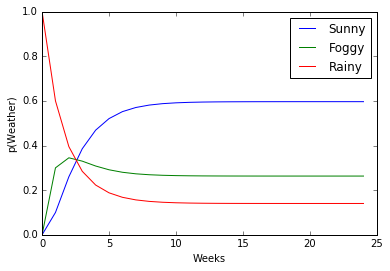

In [39]:
x = range(0,nWeeks)
sunny, = plt.plot(x,X[:,0],label='Sunny')
foggy, = plt.plot(x,X[:,1],label ='Foggy')
rainy, = plt.plot(x,X[:,2],label='Rainy')
plt.xlabel('Weeks')
plt.ylabel('p(Weather)')
plt.legend(handles=[sunny,foggy,rainy])

### Continuous state-space Markov chains

We can use the stationary distribution of a continuous state-space Markov chain in order to sample from a continuous probability distribution: we  run a Markov chain for a sufficient amount of time so that it has reached its stationary distribution, then keep the states that the chain visits as samples from that stationary distribution.

In the following example we define a continuous state-space Markov chain. The transition operator is a Normal distribution with unit variance and a mean that is half the distance between zero and the previous state, and the distribution over initial conditions is a Normal distribution with zero mean and unit variance.

To ensure that the chain has moved sufficiently far from the initial conditions and that we are sampling  from the chain’s stationary distribution,  we will choose to throw away the first 50 burn in states of the chain. We can also run multiple chains simultaneously in order to sample the stationary distribution more densely. Here we choose to run 5 chains simultaneously.

In [40]:
nBurnin = 50
nChains = 5
nTransitions = 1000
x = np.zeros((nTransitions,nChains))
x[0,:] = np.random.normal(0,1,size = (1,nChains))

In [42]:
for i in range(1,nTransitions):
    x[i,:] = np.random.normal(0.5*x[i-1,:],1,size=(1,nChains))

In [45]:
samples = x[nBurnin+1:,:]

(array([  0.,   0.,   0.,   0.,   1.,   1.,   3.,   2.,   7.,   8.,  16.,
         21.,  34.,  39.,  38.,  43.,  72.,  69.,  85.,  75.,  86.,  87.,
         49.,  47.,  36.,  30.,  36.,  24.,  19.,  11.,   3.,   2.,   4.,
          0.,   0.,   1.,   0.,   0.,   0.]),
 array([-2.        , -1.8974359 , -1.79487179, -1.69230769, -1.58974359,
        -1.48717949, -1.38461538, -1.28205128, -1.17948718, -1.07692308,
        -0.97435897, -0.87179487, -0.76923077, -0.66666667, -0.56410256,
        -0.46153846, -0.35897436, -0.25641026, -0.15384615, -0.05128205,
         0.05128205,  0.15384615,  0.25641026,  0.35897436,  0.46153846,
         0.56410256,  0.66666667,  0.76923077,  0.87179487,  0.97435897,
         1.07692308,  1.17948718,  1.28205128,  1.38461538,  1.48717949,
         1.58974359,  1.69230769,  1.79487179,  1.8974359 ,  2.        ]),
 <a list of 39 Patch objects>)

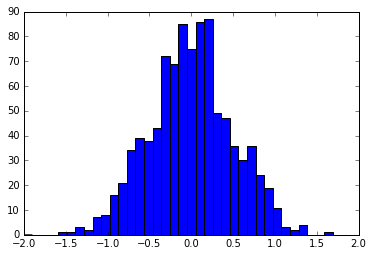

In [56]:
bins = np.linspace(-2,2,40)
plt.hist(np.mean(samples,axis=1),bins)

## Metropolis algorithm

The algorithm is as follows:
1. set $t=0$
2. generate an initial state from a prior distribution over initial states
3. repeat until $t=M$
      1. set $t=t+1$
      2. generate a proposal state $x^*$ from $q(x|x^{(t-1)})$
      3. calculate the acceptance probability $\alpha = \min(1,\frac{p(x^*)}{p(x^{(t-1)})})$
      4. draw a random number $u$ from $Unif(0,1)$
           1. if $u\leq \alpha$ accept the proposal and set $x^{(t)} = x^*$
           2. else set $x^{(t)} = x^{(t-1)}$

Suppose we want to sample from the function
$$p(x) = (1+x^2)^{-1} $$ 
We define the prior distribution of initial states from
$$\pi^{(0)}\sim \mathcal{N}(0,1)$$
The proposal distribution is defined as:
$$q(x|x^{(t-1)})\sim \mathcal{N}(x^{(t-1)},1) $$

In [83]:
nSamples = 5000
nBurnIn = 500
sigma = 1

#initialise sampler
x = np.zeros((1,nSamples))
x[0,0] = np.random.uniform(size=(1,1))

In [84]:
def p(x):
    return 1/(1+x**2)

In [94]:
#run the sampler
for i in range(1,nSamples):
    #sample from proposal
    xStar = np.random.normal(x[0,i-1],sigma)
    #calculate acceptance probability
    prob = p(xStar)/p(x[0,i-1])
    alpha = min([1,prob])
    
    #accept or reject
    u = np.random.uniform()
    if u < alpha:
        x[0,i] = xStar
    else:
        x[0,i] = x[0,i-1]

In [95]:
samples = x[0,nBurnIn:]

In [71]:
np.random.normal(0.5,sigma)

1.9155517023968194